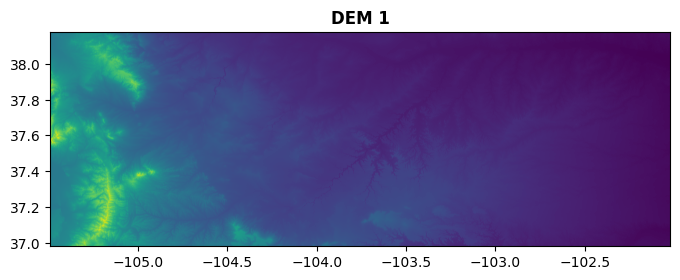

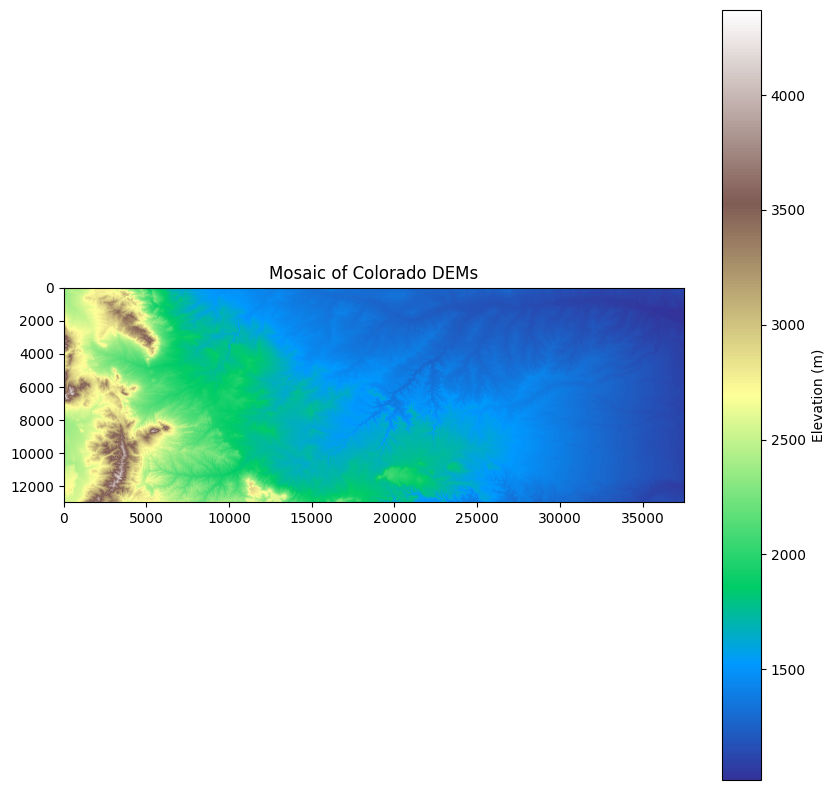

Mosaic saved to mosaic_colorado.tif


In [6]:
import tarfile
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
import os
import matplotlib.pyplot as plt
import numpy as np

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

# File paths for the tar and aux.xml files
files_to_extract = [
    'DEMs/rasters_USGS10m3.tar',
    'DEMs/rasters_USGS10m (1).tar.gz',
    'DEMs/rasters_USGS10m (2).tar.gz'
]

aux_files = [
    'DEMs/output_USGS10m4.tif.aux.xml',
    'DEMs/output_USGS10m5.tif.aux.xml',
    'DEMs/output_USGS10m.tif.aux.xml'
]

output_dir = 'extracted_dem_files'

# Step 1: Extract tar and tar.gz files
os.makedirs(output_dir, exist_ok=True)
for file in files_to_extract:
    with tarfile.open(file, 'r:*') as tar:
        tar.extractall(path=output_dir)

# List all extracted files
extracted_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.tif')]

# Step 2: Load and visualize each DEM
dems = []
for i, dem_file in enumerate(extracted_files):
    with rasterio.open(dem_file) as src:
        dems.append(src)
        plt.figure(figsize=(8, 8))
        show(src, title=f"DEM {i+1}")
        plt.show()

# Step 3: Mosaic the DEMs
# Read all DEMs as datasets for merging
datasets = [rasterio.open(dem_file) for dem_file in extracted_files]

# Merge DEMs into a single raster
mosaic, mosaic_transform = merge(datasets)

# Fix for mosaic shape: Squeeze extra dimensions if they exist
mosaic = np.squeeze(mosaic)

# Save the mosaic as a new GeoTIFF
mosaic_output = 'mosaic_colorado.tif'
with rasterio.open(
    mosaic_output,
    'w',
    driver='GTiff',
    height=mosaic.shape[0],  # Height of the raster
    width=mosaic.shape[1],   # Width of the raster
    count=1,                 # Number of bands (1 in this case)
    dtype=mosaic.dtype,
    crs=datasets[0].crs,     # Use CRS from the first dataset
    transform=mosaic_transform,  # Transformation matrix
) as dst:
    dst.write(mosaic, 1)  # Write the single band

# Step 4: Visualize the Mosaic
plt.figure(figsize=(10, 10))
plt.title("Mosaic of Colorado DEMs")
plt.imshow(mosaic, cmap='terrain')  # Directly use mosaic (no indexing needed after squeeze)
plt.colorbar(label='Elevation (m)')
plt.show()

# Cleanup: Close all raster files
for dataset in datasets:
    dataset.close()

print(f"Mosaic saved to {mosaic_output}")

In [1]:
import os
import zipfile
import tarfile
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

# Define paths to your files
tar_gz_files = ['DEMs/rasters_USGS10m (1).tar.gz', 'DEMs/rasters_USGS10m (2).tar.gz']

# Create directories for extraction
os.makedirs('extracted_rasters_1', exist_ok=True)
os.makedirs('extracted_rasters_2', exist_ok=True)

# Function to extract .tar.gz files
def extract_tar_gz(file_path, extract_to):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)
    print(f"Extracted {file_path} to {extract_to}")

# Extract all .tar.gz files
for idx, tar_gz in enumerate(tar_gz_files, start=1):
    extract_tar_gz(tar_gz, f'extracted_rasters_{idx}')

# Function to find raster files (e.g., GeoTIFF) in a directory
def find_raster_files(directory, extensions=['.tif', '.tiff', '.img']):
    raster_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                raster_files.append(os.path.join(root, file))
    return raster_files

# Collect all raster files from extracted directories
raster_dirs = ['extracted_rasters_1', 'extracted_rasters_2']
all_raster_files = []
for raster_dir in raster_dirs:
    rasters = find_raster_files(raster_dir)
    all_raster_files.extend(rasters)

print(f"Found {len(all_raster_files)} raster files.")

# Function to visualize a raster file
def visualize_raster(raster_path):
    with rasterio.open(raster_path) as src:
        fig, ax = plt.subplots(figsize=(10, 6))
        show(src, ax=ax, title=os.path.basename(raster_path))
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.show()

# Visualize all raster files
for raster in all_raster_files:
    visualize_raster(raster)

ModuleNotFoundError: No module named 'matplotlib'

# Combine the two rasters

In [2]:
# Define paths to your files
tar_gz_files = ['DEMs/rasters_USGS10m (1).tar.gz', 'DEMs/rasters_USGS10m (2).tar.gz']


In [3]:
# Create a directory to extract rasters
extracted_dir = 'extracted_rasters_combined'
os.makedirs(extracted_dir, exist_ok=True)

In [4]:
# Function to extract .tar.gz files
def extract_tar_gz(file_path, extract_to):
    try:
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Extracted {file_path} to {extract_to}")
    except tarfile.TarError as e:
        print(f"Error extracting {file_path}: {e}")

In [5]:
# Extract all .tar.gz files
for tar_gz in tar_gz_files:
    extract_tar_gz(tar_gz, extracted_dir)

Extracted DEMs/rasters_USGS10m (1).tar.gz to extracted_rasters_combined
Extracted DEMs/rasters_USGS10m (2).tar.gz to extracted_rasters_combined


In [6]:
import glob

# Function to find raster files (e.g., GeoTIFF) in a directory
def find_raster_files(directory, extensions=['.tif', '.tiff']):
    raster_files = []
    for ext in extensions:
        # Use glob to find all files recursively
        found_files = glob.glob(os.path.join(directory, '**', f'*{ext}'), recursive=True)
        raster_files.extend(found_files)
    return raster_files

In [7]:
# Collect all raster files from the extracted directory
all_raster_files = find_raster_files(extracted_dir)

print(f"Found {len(all_raster_files)} raster files.")

if not all_raster_files:
    print("No raster files found. Please check the extracted directories.")
    exit(1)

Found 1 raster files.


Visualizing individual raster files...


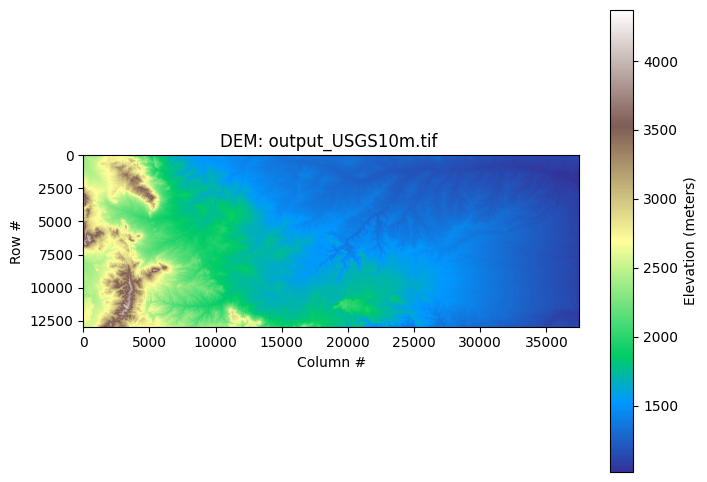

In [8]:
# Function to visualize a raster file
def visualize_raster(raster_path, title_suffix=''):
    try:
        with rasterio.open(raster_path) as src:
            # Read the first band
            band1 = src.read(1)
            
            # Handle nodata values if present
            if src.nodata is not None:
                band1 = band1.astype(float)
                band1[band1 == src.nodata] = float('nan')
            
            plt.figure(figsize=(8, 6))
            plt.imshow(band1, cmap='terrain')
            plt.colorbar(label='Elevation (meters)')
            plt.title(f"DEM: {os.path.basename(raster_path)} {title_suffix}")
            plt.xlabel('Column #')
            plt.ylabel('Row #')
            plt.show()
    except rasterio.errors.RasterioIOError as e:
        print(f"Error visualizing {raster_path}: {e}")

# Visualize all individual raster files before merging
print("Visualizing individual raster files...")
for raster in all_raster_files:
    visualize_raster(raster)